# Extract sample from an original Sentinel-2 product
This notebook shows a basic example how to extract a sample for a given Major TOM cell from a larger Sentinel-2 product.

First here

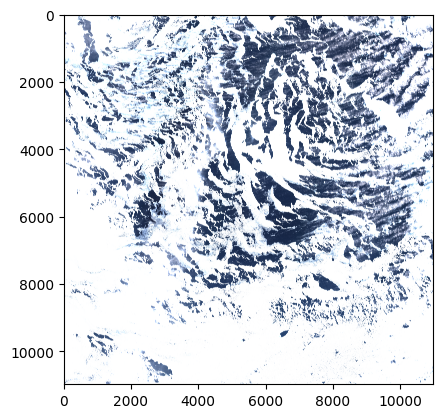

In [1]:
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt

path = 'data/S2B_MSIL2A_20200905T131909_N0500_R095_T21EVN_20230328T134830.SAFE/GRANULE/L2A_T21EVN_A018282_20200905T131912/IMG_DATA/R10m'

# Example: regular read of the entire product
with rasterio.open(path + '/T21EVN_20200905T131909_TCI_10m.jp2') as src:
    
    img = src.read()
    
plt.imshow(img.transpose(1,2,0))

## Major TOM Cell Extraction
This process consists of several steps:
1. Open Sentinel-2 file
2. Extract lat,lon of a Major TOM cell of interest
3. Map lat,lon to a footprint in the desired Major TOM zone (to facilitate that, we define `get_product_window()` below
4. Perform a windowed read of the Sentinel-2 file using the footprint

The lat,lon for a given Major TOM cell refers to the left-bottom corner. Furthermore, we apply extra padding to handle potential rotations due to the UTM projection.

In [2]:
import pyproj
from shapely.geometry import Polygon

def get_product_window(lat, lon, utm_zone=4326, mt_grid_dist = 10, box_size = 10680):
    """
        Takes a reference coordinate for top-left corner (lat, lon) of a Major TOM cell
        and returns a product footprint for a product in the specified utm_zone (needs to be extracted from a given product)


        mt_grid_dist (km) : distance of a given Major TOM grid (10 km is the default)
        box_size (m) : length 
    """
    # offset distributed evenly on both sides
    box_offset = (box_size-mt_grid_dist*1000)/2 # metres

    if isinstance(utm_zone, int):
        utm_crs = f'EPSG:{utm_zone}'
    else:
        utm_crs = utm_zone
    
    # Define transform
    transformer = pyproj.Transformer.from_crs('EPSG:4326', utm_crs, always_xy=True)

    # Get corners in UTM coordinates
    left,bottom = transformer.transform(lon, lat)
    left,bottom = left-box_offset, bottom-box_offset
    right,top = left+box_size,bottom+box_size

    utm_footprint = Polygon([
        (left,bottom),
        (right,bottom),
        (right,top),
        (left,top)
    ])

    return utm_footprint, utm_crs

In [3]:
# Initialise 
from src.grid import Grid

mt_grid = Grid(10)

/home/mczerkawski/mambaforge/envs/miko-torch/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


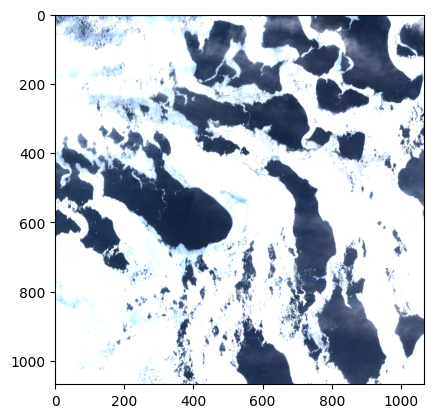

In [4]:
from rasterio.windows import Window, from_bounds

with rasterio.open(path + '/T21EVN_20200905T131909_TCI_10m.jp2') as src:
    # 1. read utm zone of the product
    src_crs = src.meta['crs']

    # 2. define major tom grid cell
    lats, lons = mt_grid.rowcol2latlon(['677D'],['317L'])

    # 3. map lat-lon to utm footprint
    window, proj = get_product_window(lats[0], lons[0], utm_zone=src_crs)
    
    # 4. read window
    img = src.read(window=from_bounds(*window.bounds, src.transform))

# 5. display
plt.imshow(img.transpose(1,2,0))